In [1]:
import torch
import argparse
import json
import os
import shutil
import importlib
import numpy as np

from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

import sampler
import backbone
import utils
from losses import TripletLoss

# #1. parse input parameters
# parser = argparse.ArgumentParser()
# parser.add_argument('--config', type=str, help="config for model", default="./config_mnist.json")
# parser.add_argument('--device', type=str, help="cuda device no.")
# parser.add_argument('--reset', '-r', action='store_true', help="whether or not to reset model dir.")
# input_args = parser.parse_args()


In [2]:
# !pip install tqdm

In [3]:
from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

                        or the CPU version with 'conda install faiss-cpu -c pytorch'. Learn more at https://github.com/facebookresearch/faiss/blob/master/INSTALL.md


In [4]:
config = './config_mnist.json'
device_no = 0
patience = 10

#2. setup configs
with open(config) as config_file:
    config = json.load(config_file)

root_dir = config['root_dir']
model_name = config['model_name']
lr_rate = config['lr_rate']
batch_size = config['batch_size']
n_epochs = config['n_epochs']
margin = config['margin']
patience = config['patience']

device = torch.device('cuda:{}'.format(device_no))

model_dir = os.path.join(root_dir, model_name)
# if input_args.reset and os.path.exists(model_dir): 
#     shutil.remove(model_dir)
# if not os.path.exists(model_dir): 
#     os.mkdir(model_dir)

#3. prepare the dataset
mean, std = 0.1307, 0.3081
train_dataset = MNIST(root='../data/MNIST',
                      train=True, 
                      download=True,
                      transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))]))
test_dataset = MNIST(root='../data/MNIST', 
                     train=False, 
                     download=True,
                     transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((mean,), (std,))]))
n_classes = 10
n_epochs = 10

#4.sampler

# offline
# X_train, X_test = sampler.offline_batching(train_dataset.data.unsqueeze(1).numpy(), train_dataset.targets.numpy(), ap_pairs=100, an_pairs=100, test_frac=0.2) # X, y --> x_pos, x_anchor, x_neg
# train_loader = DataLoader(TensorDataset(torch.tensor(X_train).float()), batch_size=batch_size)
# test_loader = DataLoader(TensorDataset(torch.tensor(X_test).float()), batch_size=batch_size)

# online
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

viz_train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False)
viz_test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


#5. set up model 
embedding_net = backbone.EmbeddingNet() # get dim
model = backbone.TripletNet(embedding_net)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
loss_fn = TripletLoss(margin=margin)



In [5]:
importlib.reload(sampler)

<module 'sampler' from '/home/anaelia/sensitivity-invariance-tradeoff/pt-metric-invariance/sampler.py'>

In [6]:
import sampler

In [7]:
from sklearn.manifold import TSNE
import utils

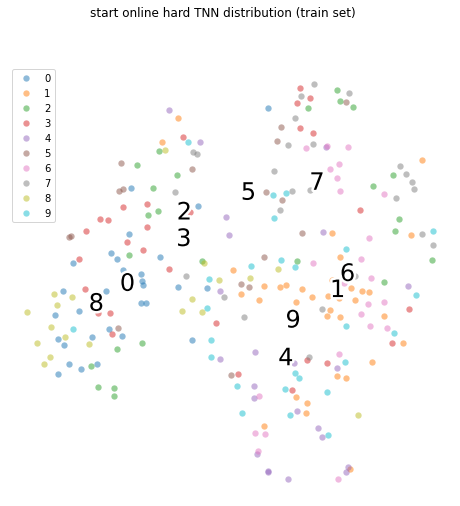

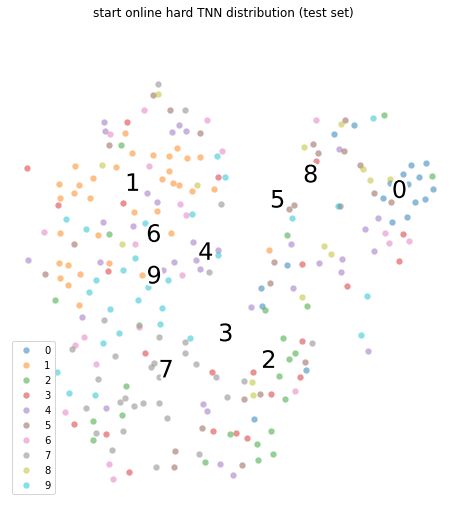

In [8]:
x_test, y_test = next(iter(viz_test_loader))
x_train, y_train = next(iter(viz_train_loader))
x_train = x_train.to(device)
x_test = x_test.to(device)
train_outputs = model.embedding_net(x_train)
test_outputs = model.embedding_net(x_test)

tsne = TSNE(random_state=0)
train_tsne_embeds = tsne.fit_transform(train_outputs.cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(test_outputs.cpu().detach().numpy())

utils.scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'start online hard TNN distribution (train set)')
utils.scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'start online hard TNN distribution (test set)')


#### euclidiean distance #####

In [9]:
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2)
mining_func = miners.TripletMarginMiner(margin = 0.2, type_of_triplets = "semihard")
accuracy_calculator = AccuracyCalculator(include = ("precision_at_1",), k = 1)

In [10]:
# miner = miners.MultiSimilarityMiner()
# loss_func = losses.TripletMarginLoss()

In [11]:
#7. train
last_epoch_improved = 0
epoch = 0
best_loss = np.inf
patience = 5

while epoch - last_epoch_improved < patience:
    running_train_loss = 0.0
    running_test_loss = 0.0
    
    # i expect the pos mask distance to be decreasing 
    # and the neg mask distance to be increasing
    running_train_pos_dist = 0.0
    running_train_neg_dist = 0.0
    running_test_pos_dist = 0.0
    running_test_neg_dist = 0.0

    for idx, data in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        embeddings = model.embedding_net(inputs)
        hard_pairs = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, hard_pairs)
        loss.backward()
        optimizer.step()
#         print(loss)
#         loss, pos_dist, neg_dist = sampler.online_mine_hard(labels, outputs, margin=margin, squared=True, device=device)
#         loss.backward()
#         optimizer.step()
        running_train_loss += loss.item()
#         running_train_pos_dist += pos_dist.item()
#         running_train_neg_dist += neg_dist.item()        
        if idx%20 == 0:
            # offline
            # print(f"Training @ epoch = {epoch}, {idx}/{len(train_loader)}, loss = {loss:.5f}", end='\r')

            #online
            print(f"Training @ epoch = {epoch}, {idx}/{len(train_loader)}, loss = {loss:.5f}", end='\r')
    train_epoch_loss = running_train_loss / len(train_loader)
#     train_pos_dist_epoch = running_train_pos_dist / len(train_loader)
#     train_neg_dist_epoch = running_train_neg_dist / len(train_loader)    
    
    # test
    with torch.no_grad():
        # offline
        # for idx, (data,) in enumerate(test_loader):
            # inputs = data.to(device)
            # anchor, positive, negative = model(x1=inputs[:,0], x2=inputs[:,1], x3=inputs[:,2])
            # loss = loss_fn(anchor, positive, negative)
        # online
        for idx, data in enumerate(test_loader):
            inputs, test_labels  = data
            inputs = inputs.to(device)
            labels = test_labels.to(device)
            embeddings = model.embedding_net(inputs)
            hard_pairs = mining_func(embeddings, test_labels)
            loss = loss_func(embeddings, test_labels, hard_pairs)
            running_test_loss += loss.item()
#             running_test_pos_dist += pos_dist.item()
#             running_test_neg_dist += neg_dist.item()     
#             accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
#                 train_embeddings,
#                 np.squeeze(test_labels),
#                 np.squeeze(train_labels),
#                 False)                  

    test_epoch_loss = running_test_loss / len(test_loader)
#     test_pos_dist_epoch = running_test_pos_dist / len(test_loader)
#     test_neg_dist_epoch = running_test_neg_dist / len(test_loader) 

    # save model/ embedding info
    if test_epoch_loss < best_loss:
        torch.save(model, os.path.join(model_dir, 'model'))
        best_loss = test_epoch_loss
        last_epoch_improved = epoch
    else:
        patience-=1

    epoch +=1
    print(f"\nPatience= {patience},train_epoch_loss = {train_epoch_loss:.5f}, test_epoch_loss = {test_epoch_loss:.5f}")

#     print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))
    print(" "*100)
print('Finished Training!!')

Training @ epoch = 0, 3740/3750, loss = 0.09007
Patience= 5,train_epoch_loss = 0.05975, test_epoch_loss = 0.03165
                                                                                                    
Training @ epoch = 1, 3740/3750, loss = 0.03268
Patience= 5,train_epoch_loss = 0.03254, test_epoch_loss = 0.02706
                                                                                                    
Training @ epoch = 2, 3740/3750, loss = 0.08002
Patience= 5,train_epoch_loss = 0.02320, test_epoch_loss = 0.02096
                                                                                                    
Training @ epoch = 3, 3740/3750, loss = 0.02305
Patience= 5,train_epoch_loss = 0.01897, test_epoch_loss = 0.01337
                                                                                                    
Training @ epoch = 4, 3740/3750, loss = 0.00000
Patience= 5,train_epoch_loss = 0.01540, test_epoch_loss = 0.01237
                          

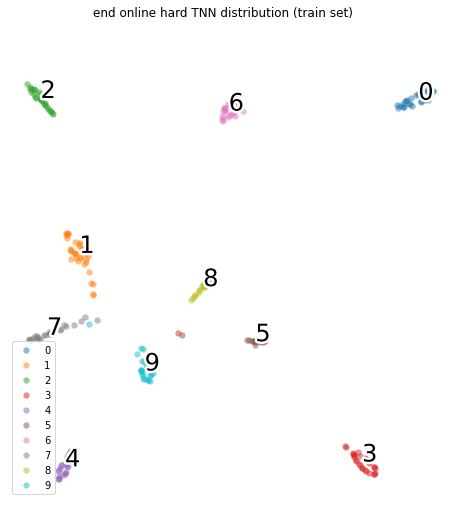

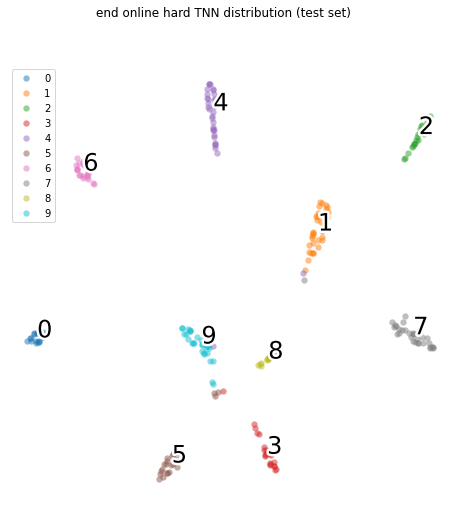

In [12]:
train_outputs = model.embedding_net(x_train)
test_outputs = model.embedding_net(x_test)

tsne = TSNE(random_state=0)
train_tsne_embeds = tsne.fit_transform(train_outputs.cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(test_outputs.cpu().detach().numpy())

utils.scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'end online hard TNN distribution (train set)')
utils.scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'end online hard TNN distribution (test set)')


## angular (cosine) distance #####

In [13]:
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.reducers import ThresholdReducer ## what is this?
from pytorch_metric_learning.regularizers import LpRegularizer
from pytorch_metric_learning import losses

reducer = reducers.ThresholdReducer(low = 0)
mining_func = miners.TripletMarginMiner(margin = 0.2, type_of_triplets = "semihard")
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = CosineSimilarity())
# loss_func = losses.TripletMarginLoss(distance = CosineSimilarity(), 
#                                      reducer = ThresholdReducer(high=0.3))



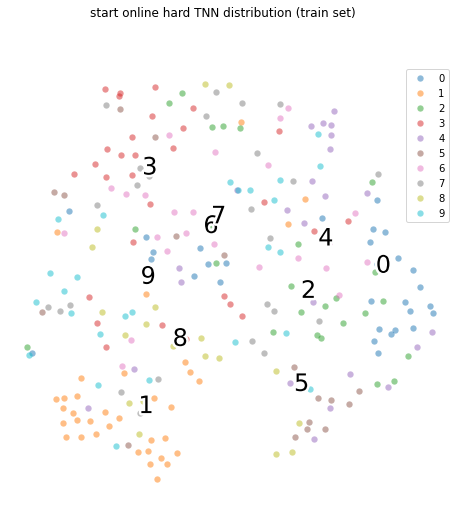

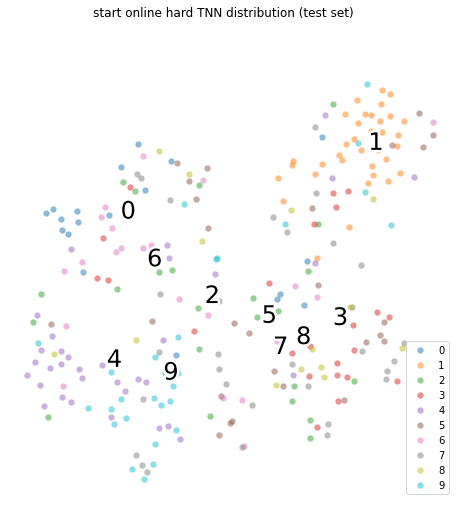

In [14]:
#reset the model
embedding_net = backbone.EmbeddingNet() # get dim
model = backbone.TripletNet(embedding_net)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)

x_test, y_test = next(iter(viz_test_loader))
x_train, y_train = next(iter(viz_train_loader))
x_train = x_train.to(device)
x_test = x_test.to(device)
train_outputs = model.embedding_net(x_train)
test_outputs = model.embedding_net(x_test)

tsne = TSNE(random_state=0)
train_tsne_embeds = tsne.fit_transform(train_outputs.cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(test_outputs.cpu().detach().numpy())

utils.scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'start online hard TNN distribution (train set)')
utils.scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'start online hard TNN distribution (test set)')


In [15]:
#7. train
last_epoch_improved = 0
epoch = 0
best_loss = np.inf
patience = 5

while epoch - last_epoch_improved < patience:
    running_train_loss = 0.0
    running_test_loss = 0.0
    
    # i expect the pos mask distance to be decreasing 
    # and the neg mask distance to be increasing
    running_train_pos_dist = 0.0
    running_train_neg_dist = 0.0
    running_test_pos_dist = 0.0
    running_test_neg_dist = 0.0

    for idx, data in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        embeddings = model.embedding_net(inputs)
        hard_pairs = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, hard_pairs)
        loss.backward()
        optimizer.step()
#         print(loss)
#         loss, pos_dist, neg_dist = sampler.online_mine_hard(labels, outputs, margin=margin, squared=True, device=device)
#         loss.backward()
#         optimizer.step()
        running_train_loss += loss.item()
#         running_train_pos_dist += pos_dist.item()
#         running_train_neg_dist += neg_dist.item()        
        if idx%20 == 0:
            # offline
            # print(f"Training @ epoch = {epoch}, {idx}/{len(train_loader)}, loss = {loss:.5f}", end='\r')

            #online
            print(f"Training @ epoch = {epoch}, {idx}/{len(train_loader)}, loss = {loss:.5f}", end='\r')
    train_epoch_loss = running_train_loss / len(train_loader)
#     train_pos_dist_epoch = running_train_pos_dist / len(train_loader)
#     train_neg_dist_epoch = running_train_neg_dist / len(train_loader)    
    
    # test
    with torch.no_grad():
        # offline
        # for idx, (data,) in enumerate(test_loader):
            # inputs = data.to(device)
            # anchor, positive, negative = model(x1=inputs[:,0], x2=inputs[:,1], x3=inputs[:,2])
            # loss = loss_fn(anchor, positive, negative)
        # online
        for idx, data in enumerate(test_loader):
            inputs, test_labels  = data
            inputs = inputs.to(device)
            labels = test_labels.to(device)
            embeddings = model.embedding_net(inputs)
            hard_pairs = mining_func(embeddings, test_labels)
            loss = loss_func(embeddings, test_labels, hard_pairs)
            running_test_loss += loss.item()
#             running_test_pos_dist += pos_dist.item()
#             running_test_neg_dist += neg_dist.item()     
#             accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
#                 train_embeddings,
#                 np.squeeze(test_labels),
#                 np.squeeze(train_labels),
#                 False)                  

    test_epoch_loss = running_test_loss / len(test_loader)
#     test_pos_dist_epoch = running_test_pos_dist / len(test_loader)
#     test_neg_dist_epoch = running_test_neg_dist / len(test_loader) 

    # save model/ embedding info
    if test_epoch_loss < best_loss:
        torch.save(model, os.path.join(model_dir, 'model'))
        best_loss = test_epoch_loss
        last_epoch_improved = epoch
    else:
        patience-=1

    epoch +=1
    print(f"\nPatience= {patience},train_epoch_loss = {train_epoch_loss:.5f}, test_epoch_loss = {test_epoch_loss:.5f}")

#     print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))
    print(" "*100)
print('Finished Training!!')

Training @ epoch = 0, 3740/3750, loss = 0.00000
Patience= 5,train_epoch_loss = 0.08006, test_epoch_loss = 0.04311
                                                                                                    
Training @ epoch = 1, 3740/3750, loss = 0.00000
Patience= 5,train_epoch_loss = 0.04581, test_epoch_loss = 0.03209
                                                                                                    
Training @ epoch = 2, 3740/3750, loss = 0.00000
Patience= 5,train_epoch_loss = 0.03121, test_epoch_loss = 0.02570
                                                                                                    
Training @ epoch = 3, 3740/3750, loss = 0.13276
Patience= 5,train_epoch_loss = 0.02433, test_epoch_loss = 0.02210
                                                                                                    
Training @ epoch = 4, 3740/3750, loss = 0.00000
Patience= 5,train_epoch_loss = 0.01952, test_epoch_loss = 0.01616
                          

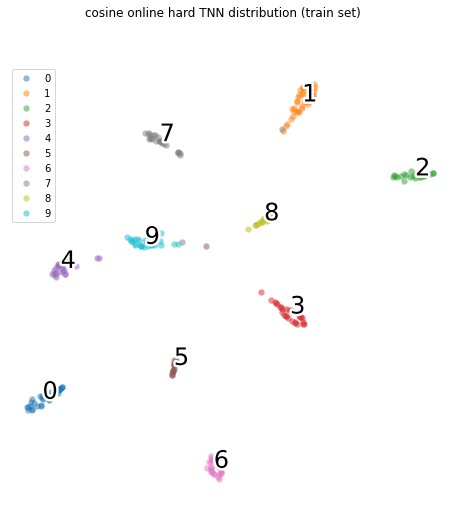

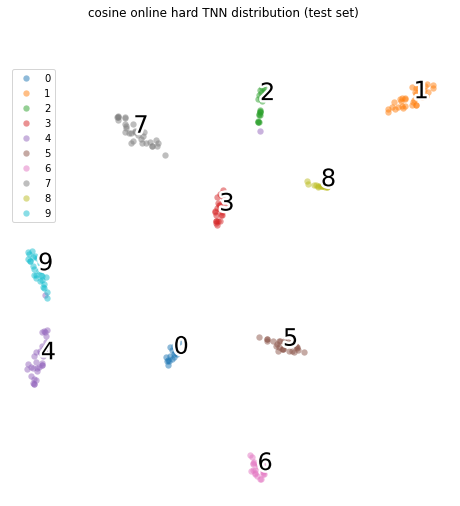

In [16]:
train_outputs = model.embedding_net(x_train)
test_outputs = model.embedding_net(x_test)

tsne = TSNE(random_state=0)
train_tsne_embeds = tsne.fit_transform(train_outputs.cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(test_outputs.cpu().detach().numpy())

utils.scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'cosine online hard TNN distribution (train set)')
utils.scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'cosine online hard TNN distribution (test set)')


## angular (cosine) distance with regularization #####

Training @ epoch = 0, 3740/3750, loss = 0.18725
Patience= 5,train_epoch_loss = 0.17159, test_epoch_loss = 0.12754
                                                                                                    
Training @ epoch = 1, 3740/3750, loss = 0.10277
Patience= 5,train_epoch_loss = 0.10978, test_epoch_loss = 0.09571
                                                                                                    
Training @ epoch = 2, 3740/3750, loss = 0.05101
Patience= 5,train_epoch_loss = 0.08675, test_epoch_loss = 0.07942
                                                                                                    
Training @ epoch = 3, 3740/3750, loss = 0.04281
Patience= 5,train_epoch_loss = 0.07125, test_epoch_loss = 0.06836
                                                                                                    
Training @ epoch = 4, 3740/3750, loss = 0.03625
Patience= 5,train_epoch_loss = 0.06305, test_epoch_loss = 0.05762
                          

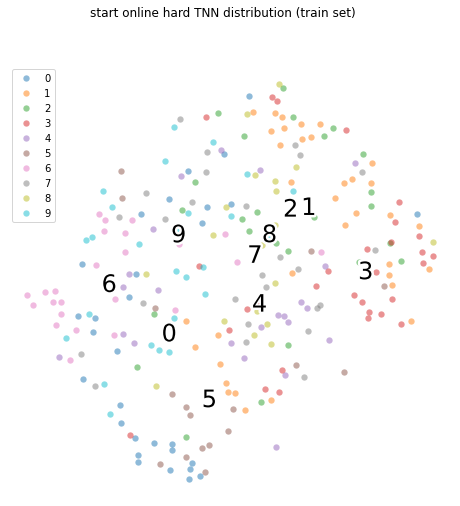

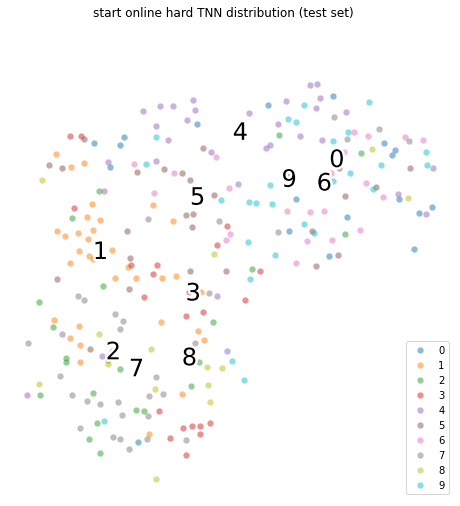

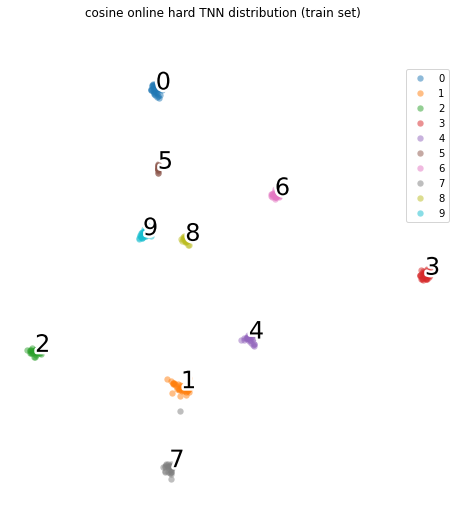

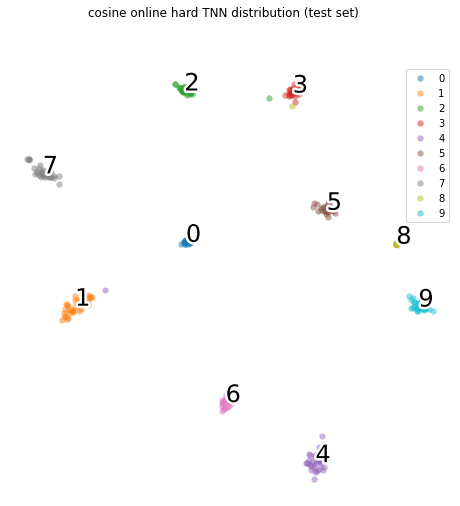

In [17]:
reducer = reducers.ThresholdReducer(low = 0)
mining_func = miners.TripletMarginMiner(margin = 0.2, type_of_triplets = "semihard")
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = CosineSimilarity(), embedding_regularizer = LpRegularizer())


#reset the model
embedding_net = backbone.EmbeddingNet() # get dim
model = backbone.TripletNet(embedding_net)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)

x_test, y_test = next(iter(viz_test_loader))
x_train, y_train = next(iter(viz_train_loader))
x_train = x_train.to(device)
x_test = x_test.to(device)
train_outputs = model.embedding_net(x_train)
test_outputs = model.embedding_net(x_test)

tsne = TSNE(random_state=0)
train_tsne_embeds = tsne.fit_transform(train_outputs.cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(test_outputs.cpu().detach().numpy())

utils.scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'start online hard TNN distribution (train set)')
utils.scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'start online hard TNN distribution (test set)')


#7. train
last_epoch_improved = 0
epoch = 0
best_loss = np.inf
patience = 5

while epoch - last_epoch_improved < patience:
    running_train_loss = 0.0
    running_test_loss = 0.0
    
    # i expect the pos mask distance to be decreasing 
    # and the neg mask distance to be increasing
    running_train_pos_dist = 0.0
    running_train_neg_dist = 0.0
    running_test_pos_dist = 0.0
    running_test_neg_dist = 0.0

    for idx, data in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        embeddings = model.embedding_net(inputs)
        hard_pairs = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, hard_pairs)
        loss.backward()
        optimizer.step()
#         print(loss)
#         loss, pos_dist, neg_dist = sampler.online_mine_hard(labels, outputs, margin=margin, squared=True, device=device)
#         loss.backward()
#         optimizer.step()
        running_train_loss += loss.item()
#         running_train_pos_dist += pos_dist.item()
#         running_train_neg_dist += neg_dist.item()        
        if idx%20 == 0:
            # offline
            # print(f"Training @ epoch = {epoch}, {idx}/{len(train_loader)}, loss = {loss:.5f}", end='\r')

            #online
            print(f"Training @ epoch = {epoch}, {idx}/{len(train_loader)}, loss = {loss:.5f}", end='\r')
    train_epoch_loss = running_train_loss / len(train_loader)
#     train_pos_dist_epoch = running_train_pos_dist / len(train_loader)
#     train_neg_dist_epoch = running_train_neg_dist / len(train_loader)    
    
    # test
    with torch.no_grad():
        # offline
        # for idx, (data,) in enumerate(test_loader):
            # inputs = data.to(device)
            # anchor, positive, negative = model(x1=inputs[:,0], x2=inputs[:,1], x3=inputs[:,2])
            # loss = loss_fn(anchor, positive, negative)
        # online
        for idx, data in enumerate(test_loader):
            inputs, test_labels  = data
            inputs = inputs.to(device)
            labels = test_labels.to(device)
            embeddings = model.embedding_net(inputs)
            hard_pairs = mining_func(embeddings, test_labels)
            loss = loss_func(embeddings, test_labels, hard_pairs)
            running_test_loss += loss.item()
#             running_test_pos_dist += pos_dist.item()
#             running_test_neg_dist += neg_dist.item()     
#             accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
#                 train_embeddings,
#                 np.squeeze(test_labels),
#                 np.squeeze(train_labels),
#                 False)                  

    test_epoch_loss = running_test_loss / len(test_loader)
#     test_pos_dist_epoch = running_test_pos_dist / len(test_loader)
#     test_neg_dist_epoch = running_test_neg_dist / len(test_loader) 

    # save model/ embedding info
    if test_epoch_loss < best_loss:
        torch.save(model, os.path.join(model_dir, 'model'))
        best_loss = test_epoch_loss
        last_epoch_improved = epoch
    else:
        patience-=1

    epoch +=1
    print(f"\nPatience= {patience},train_epoch_loss = {train_epoch_loss:.5f}, test_epoch_loss = {test_epoch_loss:.5f}")

#     print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))
    print(" "*100)
print('Finished Training!!')

train_outputs = model.embedding_net(x_train)
test_outputs = model.embedding_net(x_test)

tsne = TSNE(random_state=0)
train_tsne_embeds = tsne.fit_transform(train_outputs.cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(test_outputs.cpu().detach().numpy())

utils.scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'cosine online hard TNN distribution (train set)')
utils.scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'cosine online hard TNN distribution (test set)')



## CE + angular (cosine) distance with regularization #####

In [18]:
#         loss_func1 = MultipleLosses(
#             losses={"lossA": lossA, "lossB": lossB},
#             weights={"lossA": 1, "lossB": 0.23},
#             miners={"lossB": minerB},
#         )

#         loss_func2 = MultipleLosses(
#             losses=[lossA, lossB], weights=[1, 0.23], miners=[None, minerB]
#         )

In [19]:
ce_loss = torch.nn.CrossEntropyLoss()
l1 = 0.05
l2 = 0.001

TypeError: forward() missing 2 required positional arguments: 'input' and 'target'

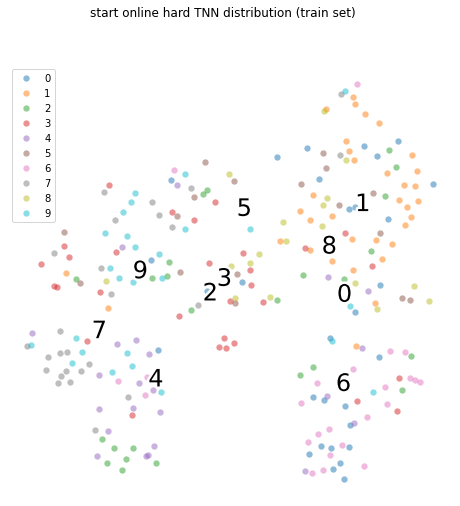

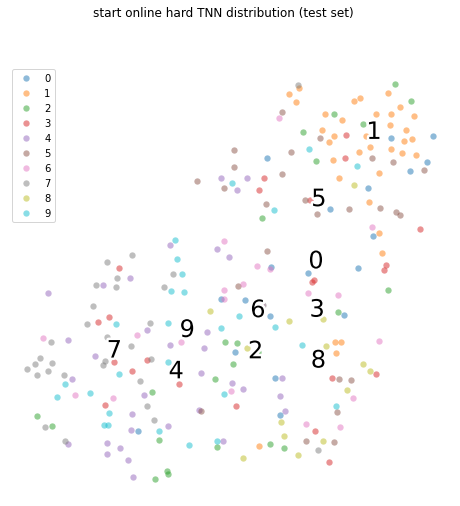

In [20]:
reducer = reducers.ThresholdReducer(low = 0)
mining_func = miners.TripletMarginMiner(margin = 0.2, type_of_triplets = "semihard")
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = CosineSimilarity(), embedding_regularizer = LpRegularizer())


#reset the model
embedding_net = backbone.EmbeddingNet() # get dim
model = backbone.TripletNet(embedding_net)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)

x_test, y_test = next(iter(viz_test_loader))
x_train, y_train = next(iter(viz_train_loader))
x_train = x_train.to(device)
x_test = x_test.to(device)
train_outputs = model.embedding_net(x_train)
test_outputs = model.embedding_net(x_test)

tsne = TSNE(random_state=0)
train_tsne_embeds = tsne.fit_transform(train_outputs.cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(test_outputs.cpu().detach().numpy())

utils.scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'start online hard TNN distribution (train set)')
utils.scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'start online hard TNN distribution (test set)')


#7. train
last_epoch_improved = 0
epoch = 0
best_loss = np.inf
patience = 10

while epoch - last_epoch_improved < patience:
    running_train_loss = 0.0
    running_test_loss = 0.0
    
    # i expect the pos mask distance to be decreasing 
    # and the neg mask distance to be increasing
    running_train_pos_dist = 0.0
    running_train_neg_dist = 0.0
    running_test_pos_dist = 0.0
    running_test_neg_dist = 0.0

    for idx, data in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        embeddings = model.embedding_net(inputs)
        hard_pairs = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, hard_pairs)
        loss += ce_losst()
        loss.backward()
        optimizer.step()
#         print(loss)
#         loss, pos_dist, neg_dist = sampler.online_mine_hard(labels, outputs, margin=margin, squared=True, device=device)
#         loss.backward()
#         optimizer.step()
        running_train_loss += loss.item()
#         running_train_pos_dist += pos_dist.item()
#         running_train_neg_dist += neg_dist.item()        
        if idx%20 == 0:
            # offline
            # print(f"Training @ epoch = {epoch}, {idx}/{len(train_loader)}, loss = {loss:.5f}", end='\r')

            #online
            print(f"Training @ epoch = {epoch}, {idx}/{len(train_loader)}, loss = {loss:.5f}", end='\r')
    train_epoch_loss = running_train_loss / len(train_loader)
#     train_pos_dist_epoch = running_train_pos_dist / len(train_loader)
#     train_neg_dist_epoch = running_train_neg_dist / len(train_loader)    
    
    # test
    with torch.no_grad():
        # offline
        # for idx, (data,) in enumerate(test_loader):
            # inputs = data.to(device)
            # anchor, positive, negative = model(x1=inputs[:,0], x2=inputs[:,1], x3=inputs[:,2])
            # loss = loss_fn(anchor, positive, negative)
        # online
        for idx, data in enumerate(test_loader):
            inputs, test_labels  = data
            inputs = inputs.to(device)
            labels = test_labels.to(device)
            embeddings = model.embedding_net(inputs)
            hard_pairs = mining_func(embeddings, test_labels)
            loss = loss_func(embeddings, test_labels, hard_pairs)
            running_test_loss += loss.item()
#             running_test_pos_dist += pos_dist.item()
#             running_test_neg_dist += neg_dist.item()     
#             accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
#                 train_embeddings,
#                 np.squeeze(test_labels),
#                 np.squeeze(train_labels),
#                 False)                  

    test_epoch_loss = running_test_loss / len(test_loader)
#     test_pos_dist_epoch = running_test_pos_dist / len(test_loader)
#     test_neg_dist_epoch = running_test_neg_dist / len(test_loader) 

    # save model/ embedding info
    if test_epoch_loss < best_loss:
        torch.save(model, os.path.join(model_dir, 'model'))
        best_loss = test_epoch_loss
        last_epoch_improved = epoch
    else:
        patience-=1

    epoch +=1
    print(f"\nPatience= {patience},train_epoch_loss = {train_epoch_loss:.5f}, test_epoch_loss = {test_epoch_loss:.5f}")

#     print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))
    print(" "*100)
print('Finished Training!!')

train_outputs = model.embedding_net(x_train)
test_outputs = model.embedding_net(x_test)

tsne = TSNE(random_state=0)
train_tsne_embeds = tsne.fit_transform(train_outputs.cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(test_outputs.cpu().detach().numpy())

utils.scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'cosine online hard TNN distribution (train set)')
utils.scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'cosine online hard TNN distribution (test set)')

